In [12]:
%pip install dgl
#imports
import os
import random
from random import sample
import numpy as np
import pandas as pd

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
import dgl.nn as dglnn

from google.colab import drive

drive.mount('/content/drive')

# path to directory consisting of facebook.txt
os.chdir("/content/drive/My Drive/Colab Notebooks") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#facebook graph
# src_dst=np.loadtxt("facebook.txt",dtype="int32")
torch.manual_seed(0)

src_dst = pd.read_csv("cora.cites", sep='\t', header=None, names=["target", "source"]).to_numpy()

src=src_dst[:,0]
dst=src_dst[:,1]

u = np.sort(list(set(np.concatenate([src, dst]))))
# print(u)
cur_ind = 0
node_index = {}

for elem in u:
  node_index[elem] = cur_ind
  cur_ind += 1

src = np.array([node_index[x] for x in src])
dst = np.array([node_index[x] for x in dst])
# x = np.array([35, 40, 114])
# print(node_index[x])
# print(np.unique(u))
# print(len(np.unique(u)))
# Edges are directional in DGL; Make them bi-directional.
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])
# Construct a DGLGraph
G = dgl.graph((u, v))
G_x = G.to_networkx().to_undirected()

print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())
print(G.nodes())
# print(G.edges())
# print(G_x[0])

private_nodes = np.array([0, 28, 15, 71, 84, 27, 72, 47, 87, 13, 52, 198, 333, 809, 279, 3, 48, 68, 543, 131])

We have 2708 nodes.
We have 10858 edges.
tensor([   0,    1,    2,  ..., 2705, 2706, 2707])


In [14]:
def find_nbr_nonnbr(G):
    """
    A routine that processes a networkx graph and emits list of neighbours and non-neighbours for each node.
    Input: NetworkX graph
    Returns: dictionary of neighbour and non-neighbors
    Do not use on large graphs since non-neighbour dictionary is O(n^3) storage, n: number of vertices. 
    """
    
    vertex_set  = set(G.nodes())
    vertex_list = list(vertex_set)
    
    nbr_dict, nonnbr_dict = {}, {}

    for node in range(len(vertex_list)):
        nbr_set = set([nbr for nbr in G[node]])
        nonnbr_set = list(vertex_set - nbr_set)

        nbr_dict[node] = nbr_set
        nonnbr_dict[node] = nonnbr_set

    return nbr_dict, nonnbr_dict

class Graph:
    def __init__(self, filename=''):
        """
        Initialize a NetworkX graph from a file with edge list.
        Raises Exception if provided file is not an edge list
        """
        # G = nx.read_edgelist(filename)
        # self.GG = G
        # self.G = nx.convert_node_labels_to_integers(G)
#         self.G = nx.DiGraph(self.G)
        G = dgl.graph((u, v))
        self.G_x = G.to_networkx().to_undirected()
        self.vertex_set = set(self.G_x.nodes())
        self.vertex_list = list(self.vertex_set)
        
    def split_train_test_private(self, test_fraction, prv_fraction=0.7):
        """
        Prepares the graph for training by creating a train, test graph with non-overlapping edges 
        Input test_fraction: Fraction of neighbours per node that make the test split.
        Returns: None
        Adds to the self test_edges_list, train_edges_list both of which are list of triples (in, out, edge-type)
        A new graph with edges from test omitted is attached to self called G_train. 
        """
        assert test_fraction<=1 and test_fraction>=0

        self.test_fraction = test_fraction
        
        nbr_dict, nonnbr_dict = find_nbr_nonnbr(self.G_x)
        self.nbr_dict, self.nonnbr_dict = nbr_dict, nonnbr_dict

        # print(nbr_dict[0])
        ## per_node_private_set consists of both private edges and non_edges-> non_empty only for private_nodes
        per_node_train_set, per_node_test_set, per_node_private_set = {}, {}, {}  
        oracle = {}         
        test_edges_list, train_edges_list = [], []        
        for node in range(len(self.vertex_list)):            
            per_node_test_set[node], per_node_train_set[node], per_node_private_set[node] = {}, {}, {}
            
            x_nbr = int(test_fraction*len(nbr_dict[node]))
            x_nonnbr = int(test_fraction*len(nonnbr_dict[node]))
            x_prv_nbr = int(prv_fraction*len(nbr_dict[node]))
            x_prv_nonnbr = int(0.25 * len(nonnbr_dict[node]))
            
#             print(x_nbr)
            
            per_node_test_set[node]['nbr'] = sample(nbr_dict[node], x_nbr)
            if node in private_nodes:
              # print('In')
              # print(nbr_dict[node])
              # print(per_node_test_set[node]['nbr'])
              per_node_private_set[node]['nbr'] =  sample(list(set(nbr_dict[node]) - set(per_node_test_set[node]['nbr'])), x_prv_nbr)
              for nbr in per_node_private_set[node]['nbr']:
                oracle[(node,nbr)] = 1
            else:
              per_node_private_set[node]['nbr'] = []
            per_node_train_set[node]['nbr'] =  list((set(nbr_dict[node])\
                                                       - set(per_node_test_set[node]['nbr'])) - set(per_node_private_set[node]['nbr']))
            ## debug statement
            # if node in private_nodes:
            #   print(node, len(per_node_train_set[node]['nbr']), len(per_node_private_set[node]['nbr']), len(per_node_test_set[node]['nbr']))
    
            per_node_test_set[node]['nonnbr'] = sample(nonnbr_dict[node], x_nonnbr)
            if node in private_nodes:
              per_node_private_set[node]['nonnbr'] =  sample(list(set(nonnbr_dict[node]) - set(per_node_test_set[node]['nonnbr'])), x_prv_nonnbr)
              for nonnbr in per_node_private_set[node]['nonnbr']:
                oracle[(node,nonnbr)] = 0
            else:
              per_node_private_set[node]['nonnbr'] = []
            per_node_train_set[node]['nonnbr'] =  list((set(nonnbr_dict[node])\
                                                  - set(per_node_test_set[node]['nonnbr'])) - set(per_node_private_set[node]['nonnbr']))
            
    
            test_edges_per_node = [(node, x) for x in per_node_test_set[node]['nbr']]
            test_non_edges_per_node  = [(node, x) for x in per_node_test_set[node]['nonnbr']]
            train_edges_per_node = [(node, x) for x in per_node_train_set[node]['nbr']]
            train_non_edges_per_node  = [(node, x) for x in per_node_train_set[node]['nonnbr']]
            
            test_edges_list.extend([(a, b, 1) for a, b in test_edges_per_node])
            test_edges_list.extend([(a, b, 0) for a, b in test_non_edges_per_node])

            train_edges_list.extend([(a, b, 1) for a, b in train_edges_per_node])
            train_edges_list.extend([(a, b, 0) for a, b in train_non_edges_per_node])

        # print('Out')
            
        self.test_edges_list = test_edges_list         
        self.train_edges_list = train_edges_list

        self.oracle = oracle
        
        self.test_edges_per_node = per_node_test_set
        self.test_non_edges_per_node = test_non_edges_per_node
        self.train_edges_per_node = per_node_train_set
        # self.test_non_edges_per_node = test_non_edges_per_node

        self.private_edges_per_node = per_node_private_set
        
        # G_train =  copy.deepcopy(self.G)
        # G_train.remove_edges([(a, b) for (a, b, label) in test_edges_list if label==1])
        train_edges_list_1 = [(a,b) for (a,b,label) in train_edges_list if label==1]

        edges_src = [a for (a,b) in train_edges_list_1]
        edges_dst = [b for (a,b) in train_edges_list_1]
        # print(edges_src)
        G_train = dgl.graph((edges_src, edges_dst))

        self.G_train = G_train

False
False
False
Private nodes = 20
No. of private edges = 522
9047


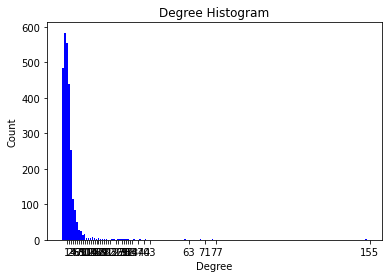

In [30]:
'''
CREATING ORIGINAL GRAPH (FOR TRAINING)
'''
import collections
import matplotlib.pyplot as plt

g = Graph()
g.split_train_test_private(test_fraction = 0.2)
graph = g.G_train

val = 812
print((28, val, 1) in g.train_edges_list)
print((28, val, 1) in g.test_edges_list)
print((28,val) in g.oracle.keys())
# print(g.oracle[(28,val)])

nx_G = graph.to_networkx().to_undirected()
degree_sequence = sorted([d for n, d in nx_G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
# for i in range(len(deg)):
    # print(deg[i], cnt[i])
# print(sorted([(x,y) for (x,y) in nx_G.degree() if y>=15], key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 2 for d in deg])
ax.set_xticklabels(deg)

priv_cnt = 0
for (key, val) in g.oracle.items():
  if val==1:
    # print(key, val)
    priv_cnt += 1

print('Private nodes = ' + str(len(private_nodes)))
# print('No. of training edges = '+str(len(g.train_edges_list)))
# print('No. of test edges = ' + str(len(g.test_edges_list)))
print('No. of private edges = ' + str(priv_cnt))

print(len(graph.edges()[0]))

In [5]:
## initializing 10D features for each node in the graph
graph.ndata['feat'] = torch.tensor(pd.read_csv("cora.content", sep='\t', header=None).drop([0, 1434], axis=1).to_numpy())

no_of_nodes = len(g.vertex_list)

neg_src, neg_dst = [], []

'''
CREATING NEGATIVE GRAPH (FOR TRAINING)

negative_graph is a graph whose edges are a subset of non_edges of the original graph
(subset of complement graph).
This is required to reduce the complexity of pairwise hinge-loss (ranking-loss) as
no. of non-edges >> no. of edges
'''

for node in g.vertex_list:
  all_neg = g.train_edges_per_node[node]['nonnbr']
  sample_size = int(0.2 * len(all_neg))
  sample_neg = np.random.choice(all_neg, size=sample_size, replace=False)
  neg_src += [node for _ in sample_neg]
  neg_dst += [node for node in sample_neg]

negative_graph = dgl.graph((neg_src, neg_dst), num_nodes=no_of_nodes)

nx_G = graph.to_networkx().to_undirected()
nx_Gm = negative_graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
# print(nx_G.edges())
# print(nx_Gm.edges())
# list(set(nx_G.edges()) & set(nx_Gm.edges())) 

## DIAGRAM OF ORIGINAL GRAPH
print(len(negative_graph.edges()[0]))

1168003


In [6]:
'''
CREATING TEST GRAPH (FOR INFERENCE)

test_graph is a graph whose edges are the test_edges and test_non_edges
of the original graph. 

There is a label (1/0) associated with each edge in test_graph, indicating whether
the edge is an edge/non-edge of the original graph.

Such a non-intuitive graph creation is necessary because during inference, we need to find
score for all node-pairs in the test_set (for ranking) and creating a graph with all
such node-pairs (to be ranked) as edges, makes it an easy and efficient routine in DGL.
'''

N = len(graph.nodes())
test_src, test_dst, edge_label = [], [], []

for node in range(N):
  all_nbr = g.test_edges_per_node[node]['nbr']
  test_src += [node for _ in all_nbr]
  test_dst += [node for node in all_nbr]
  edge_label += [1 for _ in all_nbr]

  all_nonnbr = g.test_edges_per_node[node]['nonnbr']
  test_src += [node for _ in all_nonnbr]
  test_dst += [node for node in all_nonnbr]
  edge_label += [0 for _ in all_nonnbr]

test_graph = dgl.graph((test_src, test_dst), num_nodes=no_of_nodes)
test_graph.edata['label'] = torch.tensor(edge_label)

nx_Gtest = test_graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_Gtest)
# nx.draw(nx_Gtest, pos, with_labels=True, node_color=[[.7, .7, .7]])

## DIAGRAM OF TEST GRAPH

In [7]:
'''
CREATING PRIVATE GRAPH (FOR FINDING UNCERTAIN EDGES BEFORE ORACLE-QUERY)

private_graph is a graph whose edges are the private node-pairs
of the original graph. 
'''

private_src, private_dst = [], []

for node in private_nodes:
  all_nbr = g.private_edges_per_node[node]['nbr']
  private_src += [node for _ in all_nbr]
  private_dst += [node for node in all_nbr]

  all_nonnbr = g.private_edges_per_node[node]['nonnbr']
  private_src += [node for _ in all_nonnbr]
  private_dst += [node for node in all_nonnbr]

private_graph = dgl.graph((private_src, private_dst), num_nodes=no_of_nodes)
# test_graph.edata['label'] = torch.tensor(edge_label)

nx_Gpriv = private_graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_Gpriv)
# nx.draw(nx_Gpriv, pos, with_labels=True, node_color=[[.7, .7, .7]])

## DIAGRAM OF PRIVATE GRAPH

In [8]:
'''
MODEL DEFINED HERE

GraphSAGE is for computing embeddings for each node.

DotProduct takes those embeddings and computes edge_embeddings for all edges
in the graph (takes as argument in forward(...)). Note this may not be the training graph.
Now it is clear, why we created separate negative_graph and test_graph.

Model takes 2 graphs, computes SAGE embeddings using former graph and returns scores
for edges in both former and later graph.

For reference:-
https://docs.dgl.ai/guide/training-link.html

In this implementation, input-features are 10D, output-features (embeddings) are 50D.
score(u,v) = np.dot(embedding(u), embedding(v)), which is a real number
'''

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

class DotProductPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        # self.layer1 = GCNLayer(1433, 16)
        # self.layer2 = GCNLayer(16, 7)
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, neg_g, x):
        h = self.sage(g, x)
        # x = F.relu(self.layer1(g, x))
        # h = self.layer2(g, x)
        return self.pred(g, h), self.pred(neg_g, h)

In [9]:
'''
VALIDATION (INFERENCE) ROUTINE HERE

Takes graph and score for all test node-pairs as arguments
and computes MAP for all private nodes.

Used for cross-validation during training of LP model 
'''

def validation(graph, score):
  (graph_src, graph_dst) = graph.edges()
  edge_labels = graph.edata['label']

  N = len(graph.nodes())

  ranklists, labels = {}, {}
  for node in range(N):
    ranklists[node] = []

  for i in range(len(graph_src)):
    ranklists[graph_src[i].item()].append((score[i].item(), edge_labels[i].item()))
    ranklists[graph_dst[i].item()].append((score[i].item(), edge_labels[i].item()))

  total_score, val_ct = 0, 0

  large_degree_nodes = [0, 28, 121, 71, 15, 2, 84, 328, 27, 72, 47, 122, 379, 13, 87, 173, 222, 52, 198, 333, 809, 236, 355, 279, 464, 3, 48, 64, 68, 91, 182, 543, 85, 131, 240, 509, 822, 1217, 200, 535, 642, 643]
  
  # sampled_nodes = np.random.choice(N, size=100, replace=False)
  for node in large_degree_nodes:
    ranklists[node] = np.array(sorted(ranklists[node], key = lambda x: x[0], reverse=True))
    # print('Node = '+str(node))
    # print(ranklists[node])
    # print(node)
    # print(ranklists[node])
    ground_truth_labels = ranklists[node][:,1]
    one_cnt = np.sum(ground_truth_labels)
    zero_cnt = np.sum(1-ground_truth_labels)
    if one_cnt>0 and zero_cnt>0:
      avp = np.sum((np.cumsum(ground_truth_labels)*ground_truth_labels)/np.arange(1,len(ground_truth_labels)+1))/one_cnt
      total_score+=avp
      # print(node, avp)
      val_ct+=1
  sampled_map = total_score/val_ct

  total_score, val_ct = 0, 0

  for node in private_nodes:
    ranklists[node] = np.array(sorted(ranklists[node], key = lambda x: x[0], reverse=True))
    # print('Node = '+str(node))
    # print(ranklists[node])
    ground_truth_labels = ranklists[node][:,1]
    one_cnt = np.sum(ground_truth_labels)
    zero_cnt = np.sum(1-ground_truth_labels)
    if one_cnt>0 and zero_cnt>0:
      avp = np.sum((np.cumsum(ground_truth_labels)*ground_truth_labels)/np.arange(1,len(ground_truth_labels)+1))/one_cnt
      total_score+=avp
      # print(node, avp)
      val_ct+=1
  uncertain_map = total_score/val_ct
  return sampled_map, uncertain_map

In [10]:
'''
NODE-PAIR TO QUERY FOR ACTIVE LEARNING

Objective: Find node-pair from pool-set which maximizes expected value of a separate loss.
Note: This loss is not directly a surrogate for MAP.
'''

def select_random_pairs(model, graph, negative_graph, private_graph, node_features):
  (priv_graph_src, priv_graph_dst) = private_graph.edges()
  priv_pair_count = len(priv_graph_src)

  indices = np.random.choice(priv_pair_count, size=40, replace=False)
  querying_pairs = [(priv_graph_src[index].item(), priv_graph_dst[index].item(), None) for index in indices]

  return querying_pairs

def find_uncertain_edges(model, graph, negative_graph, private_graph, node_features):
  pub_score, neg_score = model(graph, negative_graph, node_features)
  pub_score, priv_score = model(graph, private_graph, node_features)
  (pos_graph_src, pos_graph_dst) = graph.edges()
  (neg_graph_src, neg_graph_dst) = negative_graph.edges()
  (priv_graph_src, priv_graph_dst) = private_graph.edges()

  ranklists, unc_ranklists = {}, {}
  for node in private_nodes:
    ranklists[node], unc_ranklists[node] = [], []

  ## add the scores for labelled pairs to the ranklist of respective node

  for i in range(len(pos_graph_src)):
    if pos_graph_src[i].item() in private_nodes:
      ranklists[pos_graph_src[i].item()].append((pub_score[i].item(), 1))

  for i in range(len(neg_graph_src)):
    if neg_graph_src[i].item() in private_nodes:
      ranklists[neg_graph_src[i].item()].append((neg_score[i].item(), 0))

   ## add the scores of uncertain pairs to the unc_ranklist of respective node 

  for i in range(len(priv_graph_src)):
    if priv_graph_src[i].item() in private_nodes:
      unc_ranklists[priv_graph_src[i].item()].append((priv_graph_dst[i].item(), priv_score[i].item()))

  for node in private_nodes:
    ranklists[node] = sorted(ranklists[node], key=lambda x: x[0], reverse=True)
    unc_ranklists[node] = sorted(unc_ranklists[node], key=lambda x: x[1], reverse=True)

  sorted_queryable = []
  k = int(40/len(private_nodes)) + 1
  '''
  For each private node, calculate the loss for nodes with 3 highest and 3 lowest scores. Because
  of the nature of the Loss function, this heuristic is expected to works and reduces the
  complexity from O(|V|^3) -> O(|V|^2)
  '''

  for node in private_nodes:
    # sorted_pool = sorted(unc_ranklists[node],key= lambda x: x[1],reverse=True)
    choices = unc_ranklists[node] #set([sorted_pool[0], sorted_pool[1], sorted_pool[2], sorted_pool[-1], sorted_pool[-2], sorted_pool[-3]])
    # print(choices)
    # exit()
    pool_pair_losses = []

    for (j, (cur_index, cur_score)) in enumerate(choices):
      if cur_index == node:
        continue
      loss = 0
      tmp = 0
      for (i, (score, index)) in enumerate(unc_ranklists[node]):
        min_pos = min(i, j) + 1
        loss += np.abs(score - cur_score)/4
        # print(loss)
        tmp = loss
      # exit() 
      for (i, (score, label)) in enumerate(ranklists[node]):
        min_pos = min(i, j) + 1
        if score > cur_score and label == 0:
          loss += (score - cur_score)/2
        elif score < cur_score and label == 1:
          loss += (cur_score - score)/2
      # print(node, "intra-inter",tmp, loss-tmp)
      pool_pair_losses.append((node, cur_index, loss, g.oracle[(node, cur_index)]))

    per_node_queryable = sorted(pool_pair_losses, key= lambda x: x[2], reverse=True)[:k]
    # print(node, len(ranklists[node]) + len(unc_ranklists[node]), per_node_queryable[:3])
    sorted_queryable += per_node_queryable
  # print(sorted_queryable[:40])
  return sorted_queryable[:40]


In [11]:
'''
LOSS, OPTIMIZER AND TRAINING HERE

loss function to compute mean pair-wise hinge loss across all (edge, non-edge) pairs
with a common incident node.

This is common form of ranking loss we have done in class (probably surrogate of AUC).

Reference:-
https://docs.dgl.ai/guide/training-link.html

** Please check Line 37: + and - interchanged wrt reference. 
'''

def compute_loss(pos_score, neg_score, priv_score, pos, neg, prv, N):
    # Margin loss
    # print(len(pos_score))
    # print(len(neg_score))

    # print(graph_src[:1000])
    # print(neg_graph_src[:2000])
    tot_loss = 0
    # n_edges = pos_score.shape[0]

    # sampled_nodes = np.random.choice(N, size=800, replace=False)

    for i in range(N):
      # print(i)
      pos_indices, neg_indices, priv_indices = pos[i], neg[i], prv[i]
      # sampled_pos_size = min(20, len(pos_indices))
      sampled_neg_size = min(400, len(pos_indices))
      
      sampled_neg_indices = np.random.choice(neg_indices, size=sampled_neg_size, replace=False)

      for j in pos_indices:
        for k in sampled_neg_indices:
          tot_loss += (1 + neg_score[k] - pos_score[j]).clamp(min=0)

      if i in private_nodes:
        priv_indices = np.random.choice(priv_indices, size=200, replace=False)

        for j in priv_indices:
          for k in pos_indices:
            if (pos_score[k] < priv_score[j]):
              tot_loss += (1 + priv_score[j] - pos_score[k]).clamp(min=0)/2

        for j in priv_indices:
          for k in sampled_neg_indices:
            if (neg_score[k] > priv_score[j]):
              tot_loss += (1 + neg_score[k] - priv_score[j]).clamp(min=0)/2
        
    loss_mean = tot_loss.mean()
    # print(loss_mean)
    return loss_mean

torch.manual_seed(0)
## Node features must be float
node_features = graph.ndata['feat'] * 1.0
n_features = node_features.shape[1]
model = Model(n_features, 50, 50)
# model = torch.load('our_model_60')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

validation_interval = 5

## Budget and no. of edges queried till now
B = 200
edges_queried = 0

## Uncomment these lines to print status
# print('No. of edges = '+str(len(graph.edges()[0])))
# print('No. of non-edges = '+str(len(negative_graph.edges()[0])))
# print('No. of uncertain-pairs = '+str(len(private_graph.edges()[0])))

global_epoch_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


while edges_queried <= B:

  (graph_src, graph_dst) = graph.edges()
  print('Graph edges extracted')
  print(len(graph_src))
  (neg_graph_src, neg_graph_dst) = negative_graph.edges()
  print('Negative graph edges extracted')
  print(len(neg_graph_src))
  (priv_graph_src, priv_graph_dst) = private_graph.edges()
  print('Private graph edges extracted')
  print(len(priv_graph_src))

  N = len(graph.nodes())

  pos, neg, prv = {}, {}, {}

  for i in range(N):
    pos[i], neg[i], prv[i] = [], [], [] 

  for i, node in enumerate(graph_src):
    pos[node.item()].append(i)
  for i, node in enumerate(neg_graph_src):
    neg[node.item()].append(i)
  for i, node in enumerate(priv_graph_src):
    prv[node.item()].append(i)

  print('Indices for each node extracted')
  # pos_score, test_score = model(graph, test_graph, node_features)
  # sampled_map, uncertain_map = validation(test_graph, test_score)
  # print('Sampled MAP = ' + str(sampled_map))
  # print('Uncertain MAP = ' + str(uncertain_map)+'\n')
  
  ## Training for 10 epochs, cross-validation after every 5 epochs after each query.
  for epoch in range(10):
      scheduler.step()
      print('Learning rate = ' + str(optimizer.param_groups[0]['lr']))
      global_epoch_counter += 1
      print('Epoch: '+str(epoch+1))
      # negative_graph = construct_negative_graph(graph, k)
      
      pos_score, neg_score = model(graph, negative_graph, node_features)
      pub_score, priv_score = model(graph, private_graph, node_features)
      
      # neg_score = neg_score
      print('model scores computed')
      # loss = criterion(torch.cat([pos_score, neg_score]), torch.cat([torch.ones(len(pos_score), 1), torch.zeros(len(neg_score), 1)])) 
      # loss = criterion(pos_score, torch.ones(len(pos_score), 1)) * 500 + criterion(neg_score, torch.zeros(len(neg_score), 1)) 
      loss = compute_loss(pos_score, neg_score, priv_score, pos, neg, prv, N)
      # loss = compute_loss(pos_score, neg_score)
      print('Loss calculated')

      optimizer.zero_grad()
      loss.backward()
      # print('loss.backward() evaluated')
      optimizer.step()
      print(loss.item())

      if (epoch+1) % validation_interval == 0:
        torch.save(model, '/content/drive/My Drive/Colab Notebooks/model_' + str(global_epoch_counter))
        print('Epoch: ' + str(global_epoch_counter))
        pos_score, test_score = model(graph, test_graph, node_features)
        sampled_map, uncertain_map = validation(test_graph, test_score)
        print('Selected MAP = ' + str(sampled_map))
        print('Uncertain MAP = ' + str(uncertain_map)+'\n')

  # uncertain_pairs = select_random_pairs(model, graph, negative_graph, private_graph, node_features)
  uncertain_pairs = find_uncertain_edges(model, graph, negative_graph, private_graph, node_features)
  # print(uncertain_pairs)
  pos_src, pos_dst, neg_src, neg_dst, total_pairs = [], [], [], [], []

  '''
  Based on node-pairs chosen:-
  1. query the oracle
  2. remove the node-pairs from the private_graph
  3. if the oracle returns 1, add the node-pair to graph
  4  if the oracle returns 0, add the node-pair to negative_graph 
  '''

  for (u,v,loss) in uncertain_pairs:
    label = g.oracle[(u,v)]
    total_pairs.append((u,v))
    if label == 1:
      pos_src.append(u)
      pos_dst.append(v)
    else:
      neg_src.append(u)
      neg_dst.append(v)
    edges_queried += 1

  print('Oracle queries made')
    
  graph = dgl.add_edges(graph, pos_src, pos_dst)
  negative_graph = dgl.add_edges(negative_graph, neg_src, neg_dst)

  private_graph_nx = private_graph.to_networkx()
  private_graph_nx.remove_edges_from(total_pairs)
  private_graph = dgl.from_networkx(private_graph_nx)

  # Uncomment these lines to check if graphs modified properly after query
  print('query status = ' +str(edges_queried)+'/'+str(B))
  print('No. of edges = '+str(len(graph.edges()[0])))
  print('No. of non-edges = '+str(len(negative_graph.edges()[0])))
  print('No. of uncertain-pairs = '+str(len(private_graph.edges()[0])))

Graph edges extracted
9047
Negative graph edges extracted
1168003
Private graph edges extracted
13866
Indices for each node extracted
Learning rate = 0.005
Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


model scores computed
Loss calculated
269546.03125
Learning rate = 0.005
Epoch: 2
model scores computed
Loss calculated
180563.9375
Learning rate = 0.005
Epoch: 3
model scores computed
Loss calculated
164454.484375
Learning rate = 0.005
Epoch: 4
model scores computed
Loss calculated
158617.09375
Learning rate = 0.005
Epoch: 5
model scores computed
Loss calculated
155491.578125
Epoch: 5
tensor([[0.3374],
        [0.2956],
        [0.3186],
        [0.3229],
        [0.3016]], grad_fn=<SliceBackward>)
tensor([[0.3446],
        [0.3089],
        [0.3298],
        [0.2401],
        [0.3525]], grad_fn=<SliceBackward>)
Selected MAP = 0.02599838375700548
Uncertain MAP = 0.02604857460066153

Learning rate = 0.005
Epoch: 6
model scores computed
Loss calculated
152860.28125
Learning rate = 0.005
Epoch: 7
model scores computed
Loss calculated
151425.9375
Learning rate = 0.005
Epoch: 8
model scores computed
Loss calculated
150257.96875
Learning rate = 0.005
Epoch: 9
model scores computed
Loss calc

ValueError: ignored